<a href="https://colab.research.google.com/github/PatrickSampaioUSP/Propy/blob/master/PropGoverningEquations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$r = aP^n$

In [2]:
from scipy.interpolate import interp1d
import numpy as np

pressure_interp_list = [0.101, 0.1035, 0.2505, 0.3975, 0.5445, 0.6915, 0.807, 0.954, 1.101, 1.248, 1.395, 
     1.503, 1.65, 1.797, 1.944, 2.091, 2.238, 2.385, 2.532, 2.679, 2.826, 2.973, 3.12, 3.267, 3.414, 
     3.561, 3.792, 3.939, 4.086, 4.233, 4.38, 4.527, 4.674, 4.821, 4.968, 5.115, 5.262, 5.409, 5.556, 
     5.703, 5.85, 5.997, 6.144, 6.291, 6.438, 6.585, 6.732, 6.879, 7.033, 7.18, 7.327, 7.474, 
     7.621, 7.768, 7.915, 8.062, 8.209, 8.356, 8.503, 8.65, 8.797, 8.944, 9.091, 9.238, 
     9.385, 9.532, 9.679, 9.826, 9.973, 10.12, 10.267, 10.414, 10.561, 10.708, 10.855, 11.002]

r_interp_list = [2.556790241, 2.59614398,4.509524252,6.017296958,7.324422971,8.503813275,9.374044853,8.893907176,
     8.502313535,8.174027022,7.892988604,7.710209524,7.801213609,7.792563249,7.78460193,
     7.777228492,7.770362501,7.763938954,7.757904566,7.75221512,7.746833518,7.74172833,
     7.736872701,7.732243501,7.727820667,7.723586687,7.717278489,8.139304753,8.300548639,
     8.459119079,8.61515101,8.768768293,8.92008494,9.069206191,9.216229425,9.361244969,
     9.504336791,9.645583111,9.785056943,9.922826567,10.05895595,10.19350512,10.32653049,
     10.45808519,10.58821926,10.71697999,10.84441204,10.97055771,10.93248873,10.94692661,
     10.96109036,10.97499054,10.98863708,11.00203938,11.01520631,11.02814626,11.04086718,
     11.0533766,11.06568166,11.07778915,11.08970552,11.10143691,11.11298916,11.12436784,
     11.13557825,11.14662546,11.15751431,11.16824942,11.17883521,11.18927593,11.19957562,
     11.20973816,11.21976728,11.22966655,11.2394394, 11.24908913]

r_function = interp1d(pressure_interp_list, r_interp_list, kind='cubic')

class KnsbBurnrate:

  @classmethod
  def calculate_burnrate(cls, pressure):
    return r_function(pressure)


In [3]:
from math import pi

class Motor:
  def __init__(self, r_throat, D0, d0, N, D_chamber, l_grain=None, L=None, nozzle_exit_radius=None):
    self.r_throat = r_throat
    self.d_ext = D0
    self.d_int = d0
    self.grain_number = N
    self.D_chamber = D_chamber
    self.l_grain = l_grain if l_grain else (3*self.d_ext + self.d_int)/2
    self.nozzle_exit_radius = nozzle_exit_radius
    self.chamber_length = L or self.grain_number*self.l_grain

  @property
  def throat_area(self):
    return math.pi*self.r_throat**2

  @property
  def web(self):
    return (self.d_ext-self.d_int)/2

  @property
  def chamber_volume(self):
    return self.chamber_length*math.pi*(self.D_chamber**2)/4

  @property
  def propelent_volume(self):
    return (self.d_ext**2 - self.d_int**2)*self.grain_number*self.l_grain*math.pi/4

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import solve_ivp, trapz

############ Parameters #############
k = 1.1362                                            #Razão de calores específicos
cstar = 816.68                                        #Velocidade característica (m/s)
rho_grain = 1700.                                     #Densidade do grão (kg/m^3)
burn_rate = 7.72/1000                                 #Taxa de queima (m/s)
R_universal = 8.314*(10**3)                           #Constante universal dos gases (J/(kg K))
Mm = 39.9                                             #Massa molecular efetiva dos produtos de combustão (kg/kmol)
R = R_universal/Mm                                    #Constante dos produtos de combustão
T = 1600.                                             #Temperatura de combustão (K)
p_atm = 1.01325*(10**5)                               #Pressão atmosférica (Pa)
m_prod_chamber = 0.                                   #Massa dos produtos de combustão (kg)
n_cf = 0.9                                            #Eficiência do coeficiente de empuxo
g = 9.8                                               #Aceleração da gravidade (m/s^2)


################## FUNCOES ##################

calculate_pressure_steady = lambda x: x*rho_grain*burn_rate*cstar
calculate_nozzle_mass_flow = lambda pressure,throat_area: pressure*throat_area*math.sqrt(k/(R*T))*math.pow((2/(k+1)),((k+1)/(2*(k-1))))
#calculate_cf = lambda x: math.sqrt((2*k**2/(k-1))*((2/(k+1))**((k+1)/(k-1)))*(1-(p_atm/x)**((k-1)/k)))
calculate_thrust = lambda C,throat_area,x: C*throat_area*x

def calculate_cf(expansion_ratio,exit_pressure_list,pressure_list,exit_area,throat_area):
  cf = np.zeros(len(pressure_list))
  cf[0:len(cf)] = n_cf*math.sqrt((2*k**2/(k-1))*((2/(k+1))**((k+1)/(k-1)))*(1-expansion_ratio**((k-1)/k))) + (exit_pressure_list[0:len(cf)] - p_atm)*exit_area/(throat_area*pressure_list[0:len(cf)])
  return cf

def calculate_current_prop_volume(grain_number, lgrain, d_ext, d_in):
  propelent_volume = grain_number*(((d_ext**2 - d_in**2)/4)*math.pi*lgrain)
  return propelent_volume

def calculate_current_burn_area(d_ext, d_in, lgrain, n):
  transversal_area = math.pi*(d_ext**2-d_in**2)*n/2
  longitudinal_area = math.pi*lgrain*d_in*n
  return longitudinal_area + transversal_area

############### MODELO #################

def modelo(t, y, motor):
    #d0 
    #lgrain
    #pressure
    #chamber combustion product mass
    ydot = [0, 0, 0, 0]
    # final da combustão dos grãos
    if D0 > y[0]:
      burn_rate = (10**-3)*KnsbBurnrate.calculate_burnrate(y[2]/(10**6))
    else:
      burn_rate = 0
    ydot[0] = 2*burn_rate
    ydot[1] = -1*ydot[0]
    
    current_prop_volume = calculate_current_prop_volume(motor.grain_number, y[1], motor.d_ext, y[0])
    free_volume = motor.chamber_volume - current_prop_volume
    #rho_o = y[3]/free_volume
    rho_o = y[2]/(R*T)

    burn_area = calculate_current_burn_area(D0, y[0], y[1], motor.grain_number)
    
    # massa que esta saindo dos grãos
    m_dot = burn_area*rho_grain*burn_rate
    nozzle_mass_flow = calculate_nozzle_mass_flow(y[2],motor.throat_area)
    ydot[3] = m_dot - nozzle_mass_flow
    ydot[2] = ((R*T)/free_volume) * (burn_area*burn_rate*(rho_grain-rho_o) - nozzle_mass_flow)
    return ydot

def solve(func, conditions, t, motor):
    d_ext_event = lambda t, y, motor: y[0] - motor.d_ext
    d_ext_event.terminal = True

    Y = solve_ivp(func, (0,t), conditions, args=(motor,), 
                  methods='RK45', max_step=0.001, events=[d_ext_event])
    return Y

def calculate_tail_off(motor, pressure):
  pressure_list = []
  time_list = []

  current_pressure = pressure
  dt = 0.01
  time = 0.01

  exponential_coef = -R*T*motor.throat_area/(motor.chamber_volume*cstar)
  while current_pressure > p_atm:
    current_pressure = pressure*math.exp(exponential_coef*time)
    time += dt

    pressure_list.append(current_pressure)
    time_list.append(time)

  return np.array(pressure_list), np.array(time_list)


def post_processing(y, time_vector, motor):
  tail_off_pressure, tail_off_time = calculate_tail_off(motor, y[2][-1])
  burn_time_vector = np.copy(time_vector)

  time_vector = np.hstack((time_vector, tail_off_time + time_vector[-1],))
  pressure_list = np.hstack((y[2], tail_off_pressure,))
  mean_pressure = trapz(pressure_list, time_vector)/time_vector[-1]
  pressure_list = list(map(lambda x: x/10**5, pressure_list)) 

  mass_in_chamber_list = y[3]
  grain_length = y[1]
  grain_int_d = y[0]

  if not motor.nozzle_exit_radius:
    exit_area_ideal = motor.throat_area/(math.pow((k+1)/2,1/(k-1))*math.pow(p_atm/mean_pressure,1/k)*math.sqrt((k+1)*(1-math.pow(p_atm/mean_pressure,(k-1)/k))/(k-1)))
    exit_radius = math.sqrt(exit_area_ideal/math.pi)*1000.
  else:
    exit_radius = motor.nozzle_exit_radius
    exit_area_ideal = math.pi*exit_radius**2
    exit_radius = exit_radius*1000

  f = lambda x: math.pow(x,1/k)*math.sqrt((k+1)*(1-math.pow(x,(k-1)/k))/(k-1)) - motor.throat_area*math.pow((k+1)/2,1/(1-k))/exit_area_ideal
  expansion_ratio = optimize.newton(f,p_atm/mean_pressure)
  exit_pressure_list = expansion_ratio*np.copy(pressure_list)

  cf = calculate_cf(expansion_ratio,exit_pressure_list,np.copy(pressure_list)*(10**5),exit_area_ideal,motor.throat_area)
  thrust_list = np.zeros(len(cf))
  burn_rate_list = np.zeros(len(burn_time_vector))

  for j in range(len(pressure_list)):
    #cf[j]=n_cf*calculate_cf(pressure_list[j]*(10**5))
    thrust_list[j]=calculate_thrust(cf[j],motor.throat_area,pressure_list[j]*10**5)
    if j < len(burn_time_vector):
      state = [y[0][j], y[1][j], y[2][j], y[3][j]]
      burn_rate_list[j] = modelo(burn_time_vector[j],state,motor)[0]*1000/2

  average_burn_rate = trapz(burn_rate_list, burn_time_vector)/burn_time_vector[-1]
  burn_time = motor.web*1000/average_burn_rate
  kn_list = list(map(lambda x: calculate_current_burn_area(D0, x[0], x[1], N)/motor.throat_area, zip(grain_int_d, grain_length)))
  total_impulse = trapz(thrust_list, time_vector)

  specific_impulse = total_impulse/(g*motor.propelent_volume*rho_grain)
  grain_int_d = grain_int_d*1000.

  plt.figure(figsize=(16,8),dpi=80)
  plt.subplot(4,1,1)
  plt.plot(time_vector,pressure_list)
  plt.ylabel('Pressao (bar)')
  plt.subplot(4,1,2)
  plt.plot(burn_time_vector,kn_list)
  plt.ylabel('Kn')
  plt.subplot(4,1,3)
  plt.plot(time_vector,thrust_list)
  plt.ylabel('Empuxo (N)')
  plt.subplot(4,1,4)
  plt.plot(burn_time_vector,grain_int_d)
  plt.ylabel('Diametro (mm)')
  plt.xlabel('Tempo (s)')
  plt.show()

  print(f"Empuxo máximo {round(np.max(thrust_list), 2)} N")
  print(f"Impulso Específico {round(specific_impulse, 2)}")
  print(f"Pressão máxima {round(np.max(pressure_list), 2)} bar")
  print(f"Pressão média {round(mean_pressure/(10**5), 2)} bar")
  print(f"Empuxo médio {round(total_impulse/time_vector[-1], 2)} N")
  print(f"Impulso total {round(total_impulse)} Ns")
  print(f"Taxa de queima média {round(average_burn_rate, 2)} mm/s")
  print(f"Tempo de queima {round(burn_time, 2)} s")
  print(f"Raio de saída do bocal {round(exit_radius, 2)} mm")
  print(f"Razão de expansão ideal {expansion_ratio}")

#### Motor Menotti

/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `methods`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


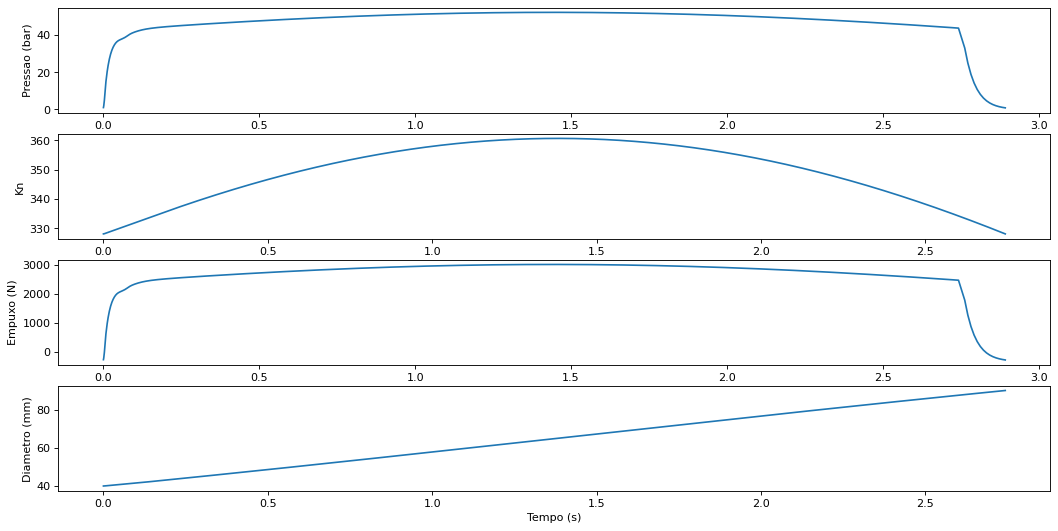

Empuxo máximo 3006.96 N
Impulso Específico 116.6
Pressão máxima 52.2 bar
Pressão média 46.74 bar
Empuxo médio 2656.58 N
Impulso total 7686.0 Ns
Taxa de queima média 9.11 mm/s
Tempo de queima 2.74 s
Raio de saída do bocal 32.81 mm
Razão de expansão ideal 0.021679309310035103


In [5]:
r_throat = 12/1000                                    #Raio da garganta do bocal (m)
D0 = 90./1000                                         #Diâmetro externo inicial (m)
N = 5                                                 #Número de grãos
d0 = 40./1000                                         #Diâmetro interno inicial (m)
D_chamber = 104./1000                                 #Diâmetro interno da câmara (m)
menotti = Motor(r_throat=r_throat, 
                D0=D0, 
                d0=d0, 
                N=N, 
                D_chamber=D_chamber)

conditions = [menotti.d_int, menotti.l_grain, p_atm, m_prod_chamber]
t = np.linspace(0,2.8,100000)



y = solve(modelo, conditions, 3, menotti)
post_processing(y.y, y.t, menotti)

#### Motor Keron


/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `methods`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


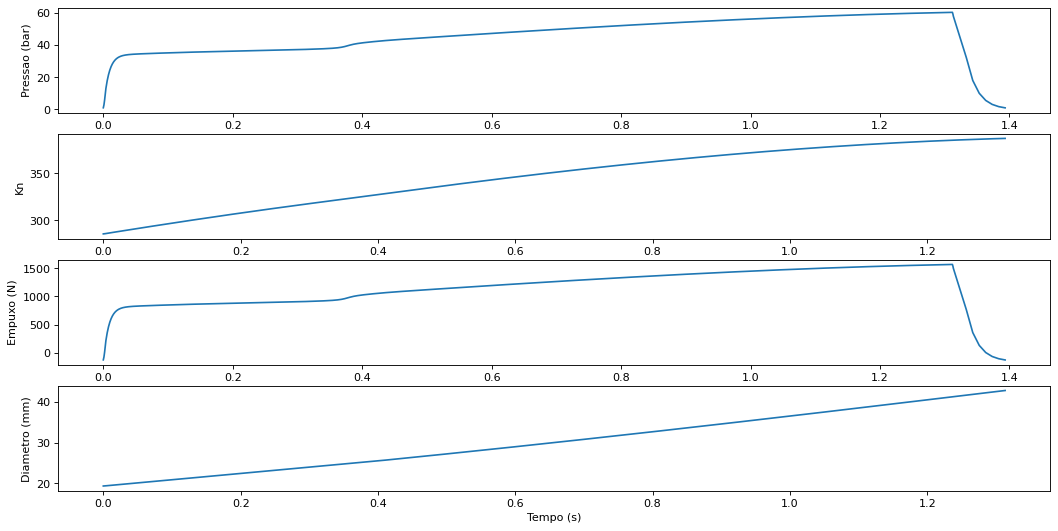

Empuxo máximo 1566.43 N
Impulso Específico 116.71
Pressão máxima 60.31 bar
Pressão média 45.73 bar
Empuxo médio 1151.56 N
Impulso total 1605.0 Ns
Taxa de queima média 8.95 mm/s
Tempo de queima 1.31 s
Raio de saída do bocal 21.69 mm
Razão de expansão ideal 0.022157519162524123


In [6]:
r_throat = 8/1000                                     #Raio da garganta do bocal (m)
D0 = 42.8/1000                                        #Diâmetro externo (m)
N = 6                                                 #Número de grãos
d0 = 19.3/1000                                        #Diâmetro interno inicial (m)
D_chamber = 48.8/1000                                 #Diâmetro interno da câmara (m)
motor_length = 750/1000                               #Comprimento do motor (m)
l_grain = 120/1000                                    #Comprimento do grão (m)
keron = Motor(r_throat=r_throat, 
                D0=D0, 
                d0=d0, 
                N=N, 
                D_chamber=D_chamber,
                L=motor_length,
                l_grain=l_grain)

conditions = [keron.d_int, keron.l_grain, p_atm, m_prod_chamber]
t = np.linspace(0,1.8,10000)

y = solve(modelo, conditions, 1.5, keron)
post_processing(y.y, y.t, keron)

In [7]:
keron.chamber_length

0.75

Pendencias:

- $\dot{M}_{nozzle}$ (check)
- $V_{camara}$ (check)
- $T_{combustion}$ (check)
- $R = \frac{\bar{R}}{M_M}$ (check)
- Tempo de queima e tail-off (check)
- $C_f$ variável com altidude
- Impulso total

#### Motor Mandioca


/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `methods`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


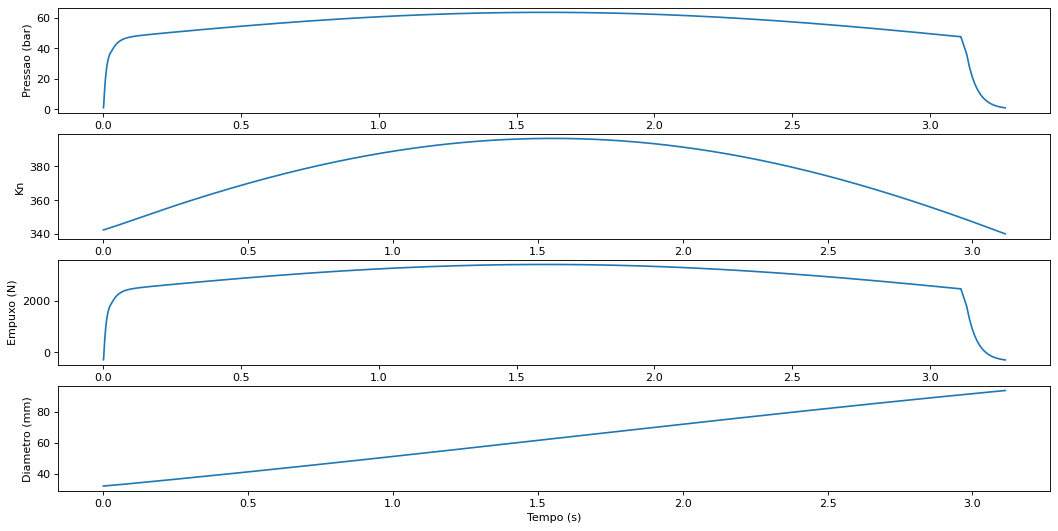

Empuxo máximo 3403.46 N
Impulso Específico 119.37
Pressão máxima 63.75 bar
Pressão média 55.35 bar
Empuxo médio 2907.85 N
Impulso total 9518.0 Ns
Taxa de queima média 9.96 mm/s
Tempo de queima 3.11 s
Raio de saída do bocal 33.5 mm
Razão de expansão ideal 0.018018830186072497


In [8]:
r_throat = 11.4/1000                                   #Raio da garganta do bocal (m)
D0 = 94/1000                                           #Diâmetro externo inicial (m)
N = 5                                                  #Número de grãos
d0 = 32/1000                                           #Diâmetro interno inicial (m)
D_chamber = 98/1000                                    #Diâmetro interno da câmara (m)
motor_length = 840/1000                                #Comprimento do motor (m)

mandioca = Motor(r_throat=r_throat, 
                D0=D0, 
                d0=d0, 
                N=N, 
                D_chamber=D_chamber,
                L=motor_length,
                nozzle_exit_radius=33.5/1000)
mandioca.l_grain = 156/1000

conditions = [mandioca.d_int, mandioca.l_grain, p_atm, m_prod_chamber]
y = solve(modelo, conditions, 98, mandioca)
post_processing(y.y, y.t, mandioca)

## Lazarus

/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `methods`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


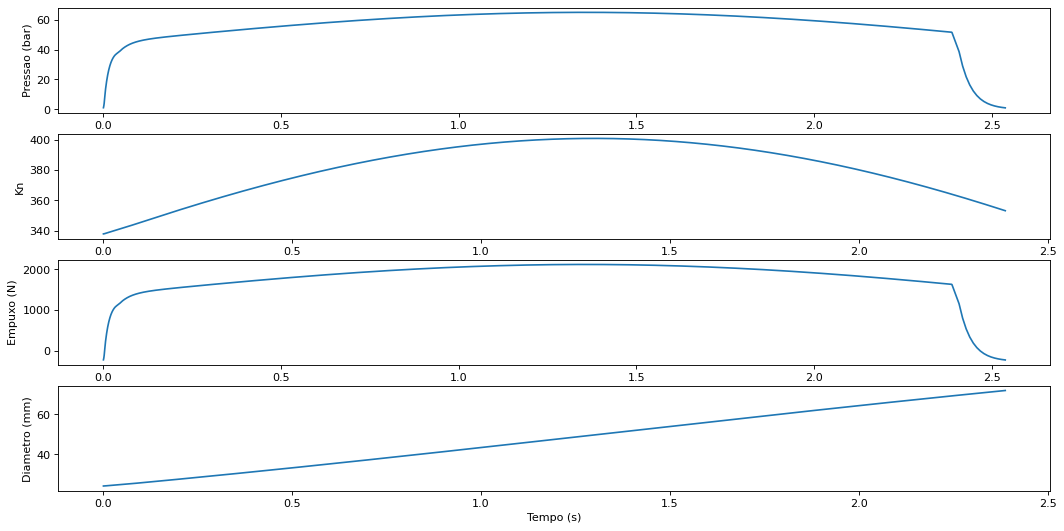

Empuxo máximo 2113.9 N
Impulso Específico 119.6
Pressão máxima 65.16 bar
Pressão média 55.88 bar
Empuxo médio 1775.68 N
Impulso total 4507.0 Ns
Taxa de queima média 10.05 mm/s
Tempo de queima 2.39 s
Raio de saída do bocal 28.7 mm
Razão de expansão ideal 0.01406645056449544


In [9]:
r_throat = 8.86/1000                                   #Raio da garganta do bocal (m)
D0 = 72/1000                                           #Diâmetro externo inicial (m)
N = 5                                                  #Número de grãos
d0 = 24/1000                                           #Diâmetro interno inicial (m)
D_chamber = 78/1000                                    #Diâmetro interno da câmara (m)
motor_length = 733.7/1000                              #Comprimento do motor (m)
#156
lazarus = Motor(r_throat=r_throat, 
                D0=D0, 
                d0=d0, 
                N=N, 
                D_chamber=D_chamber,
                L=motor_length,
                nozzle_exit_radius=28.7/1000)
lazarus.l_grain = 125/1000

conditions = [lazarus.d_int, lazarus.l_grain, p_atm, m_prod_chamber]
y = solve(modelo, conditions, 98, lazarus)
post_processing(y.y, y.t, lazarus)